In [2]:
# # references
# conditional edges:
#                     module 4, nb 4
#                     module 1, nb 1, 3, 4, 5



In [3]:
## testing the LLM api
# from langchain_core.messages import HumanMessage
# from langchain_openai import ChatOpenAI

# # Initialize the model
# model    = ChatOpenAI(model="gpt-4.1-nano-2025-04-14", temperature=0)
# test_out = model.invoke([HumanMessage("My name is Lance. How are you?")])
# test_out.content


# Self Corrective RAG Agent

In [4]:
from Self_Corrective_RAG_Agent_module import build_self_corrective_rag_agent

Self_Corrective_RAG_Agent = build_self_corrective_rag_agent()

# self_crag = self_crag.compile()

# # # example usage
# # VERBOSE = True
# # inputs = {"messages": [("human", "explain uncertainty principle in quantum mechanics")]}
# # for output in self_crag.stream(inputs):
# #     print("\n---\n")


In [5]:
a=3

# Loading env Variables

In [6]:
import os
from dotenv import load_dotenv

load_dotenv()  # Load environment variables from a .env file

# Access API keys and credentials
OPENAI_API_KEY    = os.environ["OPENAI_API_KEY"]
TIMESCALE_DB_URI  = os.environ["TIMESCALE_DB_URI"]
TAVILY_API_KEY    = os.environ["TAVILY_API_KEY"]
LANGCHAIN_API_KEY = os.environ["LANGCHAIN_API_KEY"] 
MAIN_AGENT_DB_URI = os.environ["MAIN_AGENT_DB_URI"]

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"]    = "langchain-academy"


# Calculators


In [7]:
from calculators_module import arithmetic_calculator

# # example usage
# arithmetic_calculator(2, 3, 'add')


# Useful classes/objects/functions to send and retrieve Long-term-memmories from the database


In [8]:
from Long_Term_Memory_Module import langgraph_ltm_to_pydantic_ltm, replace_ltm_in_db, SessionLocal, LTM_Table_Skeleton



# Defining the multiagent system


In [9]:
# -------------------------
# IMPORTS
# -------------------------

from IPython.display import Image, display
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, SystemMessage

from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.store.memory import InMemoryStore
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

from pydantic import BaseModel, Field
from trustcall import create_extractor

from langchain_core.documents import Document
from langchain_core.messages import merge_message_runs

import uuid
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI

from psycopg_pool import ConnectionPool
from langgraph.checkpoint.postgres import PostgresSaver

from typing import Optional, TypedDict, Literal
from datetime import datetime


# -------------------------
# DATABASE SETUP
# -------------------------

# Connection settings for PostgreSQL (used for cross-thread memory)
connection_kwargs = {"autocommit": True, "prepare_threshold": 0}

# Initialize a persistent connection pool for efficient DB access
pool = ConnectionPool(conninfo=MAIN_AGENT_DB_URI, max_size=20, kwargs=connection_kwargs)

# Create a Postgres-backed checkpointer to persist state
checkpointer = PostgresSaver(pool)
checkpointer.setup()  # Ensures that the necessary tables are created


# -------------------------
# GRAPH STATE SCHEMA
# -------------------------

class GraphState(MessagesState):
    """Defines the main data structure used for graph state management."""
    question:            str
    documents:           list[Document]
    candidate_answer:    str
    retries:             int
    web_fallback:        bool
    scrag_tool_call_id:  str


# -------------------------
# MODEL SETUP
# -------------------------

# Initialize OpenAI's GPT model
model = ChatOpenAI(model="gpt-4.1-nano-2025-04-14", temperature=0)

# In-memory store for within-thread memory (temporary and session-limited)
across_thread_memory = InMemoryStore()


# -------------------------
# SYSTEM PROMPT FOR MODEL
# -------------------------

MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You have a long-term memory which stores general user information.

<user_profile>
{user_profile}
</user_profile>

Instructions:

1. Analyze the user's message carefully.

2. If personal information is present, update the user profile via `Routing_Decision` with `update_type='prof'`.

3. Do not inform the user if you updated the profile unless they explicitly ask for it.

4. If the user's name is known, use it directly without updating the profile.

5. For calculations, call `Routing_Decision` with `update_type='calc'`.

6. For scientific queries, invoke `Routing_Decision` with `update_type='rag'`.

7. After the RAG tool's message, just reply: "I hope this answers your question."

8. Verify each calculation by calling `Routing_Decision` with `update_type='calc'`. Perform all steps by calling the calc tool.
"""


class Routing_Decision(TypedDict):
    """Specifies the type of action the assistant should take."""
    update_type: Literal['prof', 'calc', 'rag']


# -------------------------
# FUNCTION: Call model
# -------------------------

def call_model(state: GraphState, config: RunnableConfig, store: BaseStore):
    """
    Loads the user's long-term memory from the store and generates a personalized response 
    using the system prompt and conversation history.
    """
    user_id = config["configurable"]["user_id"]
    namespace = ("profile", user_id)

    # Retrieve existing long-term memory records from the database
    with SessionLocal() as db:
        user_records = db.query(LTM_Table_Skeleton).filter(LTM_Table_Skeleton.user_id == user_id).all() ######################################################

    # Set and store retrieved memory (if any)
    current_user_record = None if len(user_records) == 0 else user_records[0]
    if current_user_record:
        store.put(namespace=namespace, key=current_user_record.memory_key, value=current_user_record.memory_value)

    # Search the memory store for user profile data
    memories = store.search(namespace)
    user_profile = memories[0].value if memories else None

    # Format and invoke the model
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile)
    response = model.bind_tools([Routing_Decision], parallel_tool_calls=False).invoke(
        [SystemMessage(content=system_msg)] + state["messages"]
    )
    return {'messages': [response]}


# -------------------------
# FUNCTION: Perform calculations
# -------------------------

def calculations(state: GraphState, config: RunnableConfig, store: BaseStore):
    """
    Invokes the appropriate calculator tool and returns the formatted result.
    """
    response = model.bind_tools([arithmetic_calculator], parallel_tool_calls=False).invoke(state["messages"][:-1])
    args = response.tool_calls[0]['args']
    result = arithmetic_calculator(args['n1'], args['n2'], args['ops'])
    content = f"{args['n1']} {args['ops']} {args['n2']} = {result}"

    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": content, "tool_call_id": tool_calls[0]['id']}]}


# -------------------------
# FUNCTION: Pass message to RAG agent
# -------------------------

def interim_rag_node(state: GraphState, config: RunnableConfig, store: BaseStore):
    """
    Forwards the request to the self-corrective RAG agent.
    """
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "Passed on the request to self_corrective_rag_agent subgraph", "tool_call_id": tool_calls[0]['id']}]}


# -------------------------
# USER PROFILE MODEL
# -------------------------

class Profile(BaseModel):
    """Represents structured user profile information."""
    name: Optional[str] = Field(description="User's name", default=None)
    bachelor: Optional[str] = Field(description="Bachelor's degree subject(s)", default=None)
    master: Optional[str] = Field(description="Master's degree subject(s)", default=None)
    phd: Optional[str] = Field(description="PhD subject(s)", default=None)
    connections: list[str] = Field(description="User's personal connections (friends, family, coworkers)", default_factory=list)
    interests: list[str] = Field(description="User's interests", default_factory=list)


# -------------------------
# TRUSTCALL EXTRACTOR SETUP
# -------------------------

# Create a Trustcall extractor to update the user profile
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

# Instruction to guide Trustcall memory extraction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. Specifically, extract the subject in which the user earned their bachelor's degree.

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""


# -------------------------
# FUNCTION: Update user profile
# -------------------------

def update_profile(state: GraphState, config: RunnableConfig, store: BaseStore):
    """
    Uses the Trustcall extractor to analyze chat history and update the user's long-term memory.
    """
    user_id = config["configurable"]["user_id"]
    namespace = ("profile", user_id)

    # Retrieve current user record (if any) and load it into the memory store
    with SessionLocal() as db:
        user_records = db.query(LTM_Table_Skeleton).filter(LTM_Table_Skeleton.user_id == user_id).all() ###############################################

    current_user_record = None if len(user_records) == 0 else user_records[0]
    if current_user_record:
        store.put(namespace=namespace, key=current_user_record.memory_key, value=current_user_record.memory_value)

    # Prepare existing memory for the extractor
    existing_items = store.search(namespace)
    existing_memories = [(item.key, "Profile", item.value) for item in existing_items] if existing_items else None

    # Merge messages and format instruction
    updated_messages = list(merge_message_runs(messages=[
        SystemMessage(content=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat()))
    ] + state["messages"][:-1]))

    # Run the extractor
    result = profile_extractor.invoke({"messages": updated_messages, "existing": existing_memories})

    # Store updated memories
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace, rmeta.get("json_doc_id", str(uuid.uuid4())), r.model_dump(mode="json"))

    # Persist the memory to the database
    current_pydantic_ltm = langgraph_ltm_to_pydantic_ltm(store.search(namespace)[0])
    with SessionLocal() as db:
        replace_ltm_in_db(current_pydantic_ltm, db)

    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id": tool_calls[0]['id']}]}


# -------------------------
# FUNCTION: Routing logic
# -------------------------

def route_message(state: GraphState, config: RunnableConfig, store: BaseStore) -> Literal['calculations', 'update_profile', 'self_corrective_rag_agent', END]:
    """
    Determines the next action based on tool call arguments:
    - Profile update
    - Calculation
    - RAG query
    """
    message = state['messages'][-1]
    if len(message.tool_calls) == 0:
        return END

    tool_call = message.tool_calls[0]
    action = tool_call['args']['update_type']

    if action == "prof":
        return "update_profile"
    elif action == "calc":
        return "calculations"
    elif action == "rag":
        return "interim_rag_node"
    else:
        raise ValueError(f"Unexpected update_type: {action}")


# -------------------------
# BUILD THE GRAPH
# -------------------------

builder = StateGraph(GraphState)

builder.add_node("call_model", call_model)
builder.add_node("calculations", calculations)
builder.add_node("update_profile", update_profile)
builder.add_node("interim_rag_node", interim_rag_node)
builder.add_node("self_corrective_rag_agent", Self_Corrective_RAG_Agent.compile())

builder.add_edge(START, "call_model")
builder.add_edge("interim_rag_node", "self_corrective_rag_agent")
builder.add_edge("self_corrective_rag_agent", END)
builder.add_edge("calculations", "call_model")
builder.add_edge("update_profile", "call_model")

builder.add_conditional_edges('call_model', route_message, ['calculations', 'update_profile', "interim_rag_node", END])

memory = MemorySaver()

# Compile the graph with persistent checkpointer and in-memory store
graph = builder.compile(checkpointer=memory, store=across_thread_memory) #checkpointer



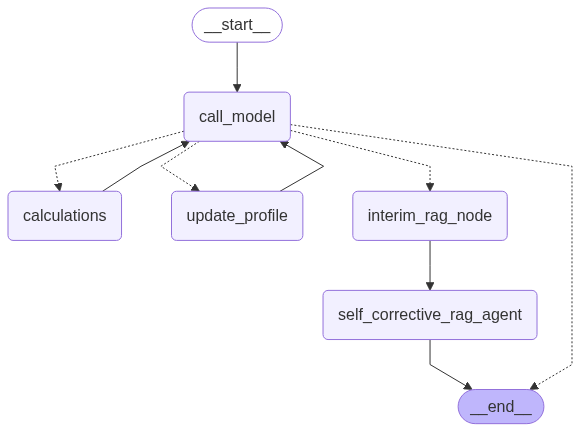

In [10]:
# View
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print(graph.get_graph().draw_ascii(), '\n\n')
    print(graph.get_graph().draw_mermaid())
# https://mermaid.live/edit#pako:eNp1Ul2PmzAQ_CvWVlESCSjfSXynvFx-Qp9aTsgHdrBqbGTMtVfEf6-BHHdU6duOZ3Zn1nYPhSopYNhsei65wajfMqF-FRXRZjuiotOv1FZbwSUlejsMw2aTyasmTYW-XR4ymZk8b43V5_nux2NzXtDj1-b8vMcYM65bMwoLIkReW0ex-yj3N6boBDFcyXb3GUxs15TE0LzRinFBd2u4nyNQWS4BpnqxF2R2X4Ih1z2jjwAP_wa4x689_zPhBpHrzfQy8a5gPfKu5LbKzNk92gtlqKSMdMIg2yXwFxYynzFnfB63ovxaGRx44aphuv9J7qqGFNy8YX8lGG_oNu6FvaSsAAeumpeAje6oAzXVNRkh9JlEKANT0ZpmgG1ZEv0zg0wOtqch8rtS9XubVt21AsyIaC2a171wYv9OvZxquyDVT6qTBnB68qchgHv4DThIDp4fB2kchFESJUGSOvBmj1PvEPtRcAxPxyg6HeN4cODP5Ot7aRBExzSOQj9K0jA5DH8BLyP9pw


In [22]:
print(graph.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	call_model(call_model)
	calculations(calculations)
	update_profile(update_profile)
	interim_rag_node(interim_rag_node)
	self_corrective_rag_agent(self_corrective_rag_agent)
	__end__([<p>__end__</p>]):::last
	__start__ --> call_model;
	calculations --> call_model;
	interim_rag_node --> self_corrective_rag_agent;
	self_corrective_rag_agent --> __end__;
	update_profile --> call_model;
	call_model -.-> calculations;
	call_model -.-> update_profile;
	call_model -.-> interim_rag_node;
	call_model -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [23]:
# # We supply a thread ID for short-term (within-thread) memory
# # We supply a user ID for long-term (across-thread) memory 
# config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# # User input 
# inp = {'messages': [HumanMessage(content='what is the final answer if i add 4 into 2, then subtract from it 1, then multiply by 1, then divide that by 2?')]}

# # Run the graph
# for chunk in graph.stream(inp, config, stream_mode="values"):
#     chunk["messages"][-1].pretty_print()


In [24]:
# abhi koi memory show nahi hogi, cuz abhi agent aik bar bhi run hi nahi hua, pehli node main ja k, memmory datbase say yahan add hogi
# Check for updated instructions
user_id = "1"

# Search 
for memory in across_thread_memory.search(("profile", user_id)):
    print(memory.value)

In [ ]:



# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="Hi do u remember my name?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

Hi do u remember my name?


In [ ]:
# Check for updated instructions
user_id = "1"

# Search 
for memory in across_thread_memory.search(("profile", user_id)):
    print(memory.value)

In [ ]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="I have a master in physics as well. Update my profile.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


In [ ]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="No, sorry my name is Lance. kindly update my profile")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


In [ ]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="I am interested in physics and maths.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


In [ ]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="okay then update my interests")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


In [ ]:
# Check for updated instructions
user_id = "1"

# Search 
for memory in across_thread_memory.search(("profile", user_id)):
    print(memory.value)


In [ ]:
memory


In [ ]:
for m in graph.get_state(config=config).values['messages']:
    m.pretty_print()

In [ ]:
# send longterm memmory to the database as well, retrieve it from the database as well.
# in the main table use userid as the primary key.


In [ ]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="What is the answer of (((5+2)*3)-1)/(3)? Do it step by step.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


In [ ]:
for m in graph.get_state(config=config).values['messages']:
    m.pretty_print()


# RAG

In [11]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="explain uncertainty priciple in quantum mechanics")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

explain uncertainty priciple in quantum mechanics
================================== Ai Message ==================================
Tool Calls:
  Routing_Decision (call_v6A51578NotUtzKhQyMeDbj6)
 Call ID: call_v6A51578NotUtzKhQyMeDbj6
  Args:
    update_type: rag
================================= Tool Message =================================

Passed on the request to self_corrective_rag_agent subgraph
---RETRIEVE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: ANSWER NOT GROUNDED, RETRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: ANSWER NOT GROUNDED, RETRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: ANSWER NOT GROUNDED, RETRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: ANSWER GROUNDED, NOW CHECK RELEVANCE---
---DECISION: ANSWER RELEVANT---
---FINALIZING THE RESPONSE---
================================== Ai Message ==================================

The 